# Dynamische Programmierung
## Indirektes Verfahren, Randwertproblem

In [9]:
import numpy as np
import scipy as sp
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

from scipy.optimize import minimize, Bounds, LinearConstraint
from scipy import sparse
import scipy.signal as sig
from scipy.integrate import odeint

## 1. Modell

In [10]:
global nx, nu, nxu, N, t, Ta, S, M, Q, R, b_


t_end = 4
N = 50
t = np.linspace(0,t_end,N)

# Anzahl an Zuständen und Eingängen
nx = 4
nu = 1
nxu = nx+nu

Ta = t_end/N

S = np.zeros((nx,nx))
S[2,2] = 5
M = np.eye(4)
Q = np.eye(4)*5
R = np.array([[0.1]])
b_ = [0,0,0,0]

In [11]:
# Parameter
global J,a,m,d,g

J = 0.0361  # kgm²
a = 0.42    # m
m = 0.3553  # kg
d = 0.005   # Nms
g = 9.81    # m/s²

In [35]:
# System dynamic

def System_dynamic(t,x):
    dx = np.zeros(nxu)
    u = x[nxu-1]
    dx[0] = x[1]
    dx[1] = (m*g*np.sin(x[1])+m*a*np.cos(x[0])*u-d*x[1])/(J+m*a**2) 
    dx[2] = x[3]
    dx[3] = u

    return dx


In [12]:
# Ableitungen

def dfdx(x,u):    
    A =np.zeros((nx,nx))
    A[0,1] = (m*g*np.cos(x[0])-m*a*np.sin(x[0])*u)/(J+m*a**2)
    A[1,1] = -d/(J+m*a**2)
    A[2,3] = 1
    return A

def dfdu(x,u):    
    B = np.zeros((nx,nu))
    B[1,0] = (m*a*np.cos(x[0]))/(J+m*a**2)
    B[3,0] = 1
    return B

## Minimization with Scipy minimize
### Setup Problem

In [13]:
# Kostenfunktion

l  = lambda x,Q: 1+ x.T@Q@x
dl = lambda x,Q: Q@x               



def cost(y):
    # y = [x0 u0, x1 u1, ....., xN uN]   mit x = [x0 x1 x2 x3 ..], und u = [u0,u1,u2,u3,...]
    # P = diag[Q,R,Q,R,....., QN, RN*0]
    #      
    
    cost_ = (l(y[-nxu:-nu],S))/2                                                       # Endkostenterm 0.5*xSx
    
    for k in range(0,N-1):
        k0 = (k)*nxu      
        k1 = (k+1)*nxu    
       
        cost_ += (t[k+1]-t[k])/2*( l(y[k0:k0+nxu], block_diag(Q,R))+ l(y[k1:k1+nxu],block_diag(Q,R)) )    #  laufende Kosten  1 + 0.5*(xQx + uRu)
               
    return cost_

def costdx(y):
    # Ableitung der Kosten      
    
    dJdy = np.zeros((nxu*N))
    dJdy[-nxu:] = dl(y[-nxu:],block_diag(S,R*0))   
    for k in range(0,N-1):
        k0 = (k)*nxu      
        k1 = (k+1)*nxu    
        #print(k0,k1)  
        dJdy[k0:k1] = (t[k+1]-t[k])/2*( dl(y[k0:k0+nxu],block_diag(Q,R))+ dl(y[k1:k1+nxu],block_diag(Q,R)) )     
    
    return dJdy

In [14]:
global x0, xN, xNN
x0 = np.array([np.pi,0,0,0])
#x0 = np.array([2,2,2,2])
xN = np.array([0,0,0,0])
xNN = np.array([0,0,0,0,0])

# 2-Randwertproblem Lösung mittels scipy_bvp

[  1.     1.     1.   -10.     0.91]


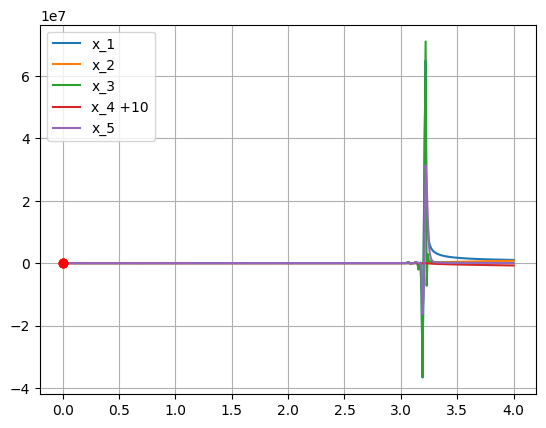

In [15]:
def System(t,x):
    dx = np.zeros((5,len(t)))
    
    for i in range(0,len(t)):

        dx[0,i] = x[0,i]*(x[2,i]-x[0,i])/(2*x[1,i])
        dx[1,i] = -0.5*(x[2,i]-x[0,i])
        dx[2,i] = (0.9-1000*(x[2,i]-x[4,i])-0.5*x[2,i]*(x[2,i]-x[0,i]))/x[3,i]
        dx[3,i] = 0.5*(x[2,i]-x[0,i])
        dx[4,i] = -100*(x[4,i]-x[2,i])        
    
    return dx

def bc(ya,yb):
    
    return [ya[0]-1,ya[1]-1,ya[2]-1,ya[3]+10, yb[4]-yb[2] ] 

y = np.zeros((5,len(t))) 

y0 = np.zeros((5,len(t))) 

# Boundary conditions
ya = y0[0,:]    # Startbedingung
yb = y0[-1,:]   # Endbedingung

# # Startlösung 
for i in range(0,len(t)):
    y0[0,i] = 1
    y0[1,i] = 1
    y0[2,i] = -4.5*t[i]**2 +8.91*t[i] + 1
    y0[3,i] = -10
    y0[4,i] = -4.5*t[i]**2+9*t[i] + 0.91              

#plt.plot(t,y[2,:])
print(y0[:,0])

from scipy.integrate import solve_bvp

res = solve_bvp(System, bc, t, y0)

plt.plot(res.x,res.y[0],label = 'x_1')
plt.plot(res.x,res.y[1],label = 'x_2')
plt.plot(res.x,res.y[2],label = 'x_3')
plt.plot(res.x,res.y[3]+10,label = 'x_4 +10')
plt.plot(res.x,res.y[4],label = 'x_5')
plt.grid()
plt.legend()

# Plotten der Randwerte
plt.plot(np.zeros(4), [1,1,1,0], 'ro')




In [16]:
'''
import sympy as  sym
import numpy as np
Q = np.eye(4)*5
R = np.array([[0.1]])
x1,x2,x3,x4,m,g,d,J, a, u , p1,p2,p3,p4 =  sym.symbols("x1 x2 x3 x4 m g d J a u p1 p2 p3 p4 ")

xd = sym.Matrix(
    [x2, 
      (m*g*a*sym.sin(x1)-d*x2+m*a*sym.cos(x1)*u)/(J+m*a**2),
      x4,
      u])
#sym.init_printing()
display(xd)

x = sym.Matrix([x1,x2,x3,x4])
p = sym.Matrix([p1,p2,p3,p4])

H =  1 + 1/2*(x.dot(Q.dot(x)) + R*u**2) +p.T@xd
display(H)
Hdu = sym.diff(H,u)
display(Hdu)
sym.solve(Hdu,u)
'''


'\nimport sympy as  sym\nimport numpy as np\nQ = np.eye(4)*5\nR = np.array([[0.1]])\nx1,x2,x3,x4,m,g,d,J, a, u , p1,p2,p3,p4 =  sym.symbols("x1 x2 x3 x4 m g d J a u p1 p2 p3 p4 ")\n\nxd = sym.Matrix(\n    [x2, \n      (m*g*a*sym.sin(x1)-d*x2+m*a*sym.cos(x1)*u)/(J+m*a**2),\n      x4,\n      u])\n#sym.init_printing()\ndisplay(xd)\n\nx = sym.Matrix([x1,x2,x3,x4])\np = sym.Matrix([p1,p2,p3,p4])\n\nH =  1 + 1/2*(x.dot(Q.dot(x)) + R*u**2) +p.T@xd\ndisplay(H)\nHdu = sym.diff(H,u)\ndisplay(Hdu)\nsym.solve(Hdu,u)\n'

In [38]:
# System dynamic

nx = 4
# Eingangsbeschränkung
umax = 12
def System_dynamic(t,x):
    '''
    x:         [x,lamda]
    '''
    dx = np.zeros((nx*2,len(t)))

    for i in range(0, len(t)):
        u       = -1/R*(x[5,i]*m*a*np.cos(x[0,i])/(J+m*a**2) + x[7,i])        
        u       = min(umax,max(-umax,u))        
        dx[0,i] = x[1,i]
        dx[1,i] = (m*g*np.sin(x[1,i])+m*a*np.cos(x[0,i])*u-d*x[1,i])/(J+m*a**2) 
        dx[2,i] = x[3,i]
        dx[3,i] = u
        dx[nx:nx*2,i] = -Q@x[:nx,i] - dfdx(x[:nx,i],u)@x[nx:nx*2,i]
    return dx

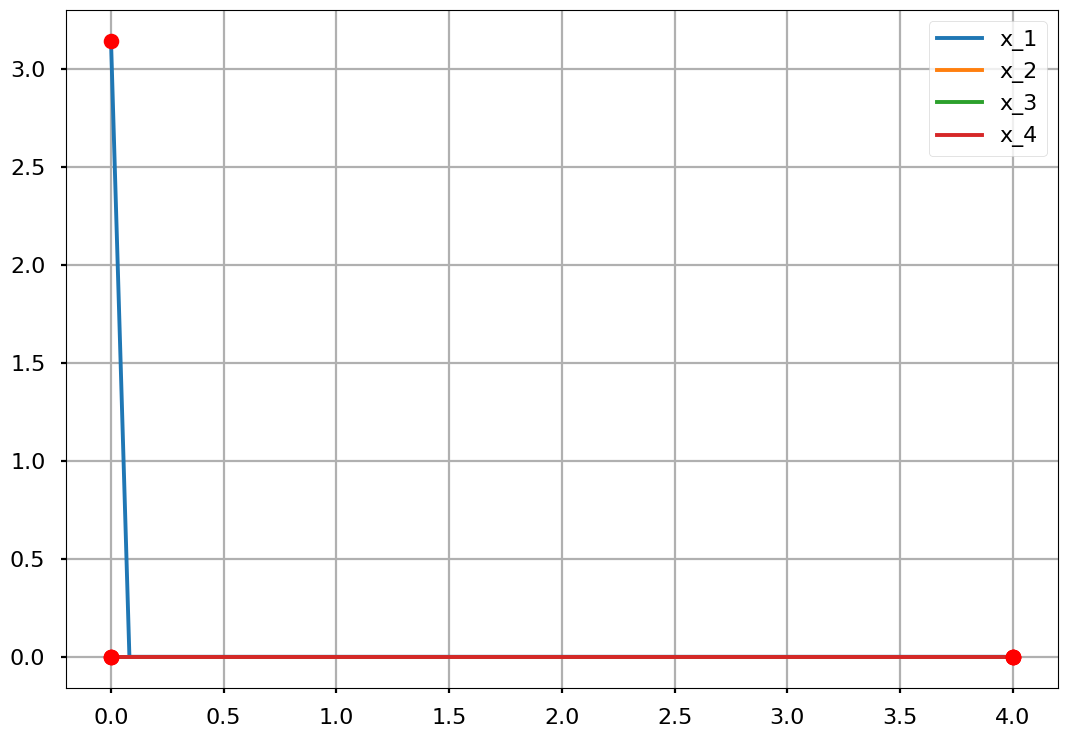

In [39]:
x0 = [np.pi, 0,0,0]
xf = [0,0,0,0]
def bc(ya,yb):
    
    return np.hstack([ya[:nx]-x0,yb[0]-xf[0], yb[1]-xf[1], yb[3]-xf[3] , yb[5] ])


# Boundary conditions
y0 = np.zeros((nx*2,len(t))) 
y0[:nx,0] = x0
# Startlösung 
for i in range(1,len(t)):
    y0[0,i] = 0
    y0[1,i] = 0
    y0[2,i] = 0
    y0[3,i] = 0   
    y0[4,i] = 1
    y0[5,i] = 1
    y0[6,i] = 1
    y0[7,i] = 1              

#plt.plot(t,y[2,:])

from scipy.integrate import solve_bvp

tol = 1e-3
iter = 1e3

res = solve_bvp(System_dynamic, bc, t, y0)


plt.plot(res.x,res.y[0],label = 'x_1')
plt.plot(res.x,res.y[1],label = 'x_2')
plt.plot(res.x,res.y[2],label = 'x_3')
plt.plot(res.x,res.y[3],label = 'x_4')
plt.grid()
plt.legend()

# Plotten der Randwerte
plt.plot(np.zeros(4), [np.pi,0,0,0], 'ro')
plt.plot(np.ones(4)*t_end, [0,0,0,0], 'ro')




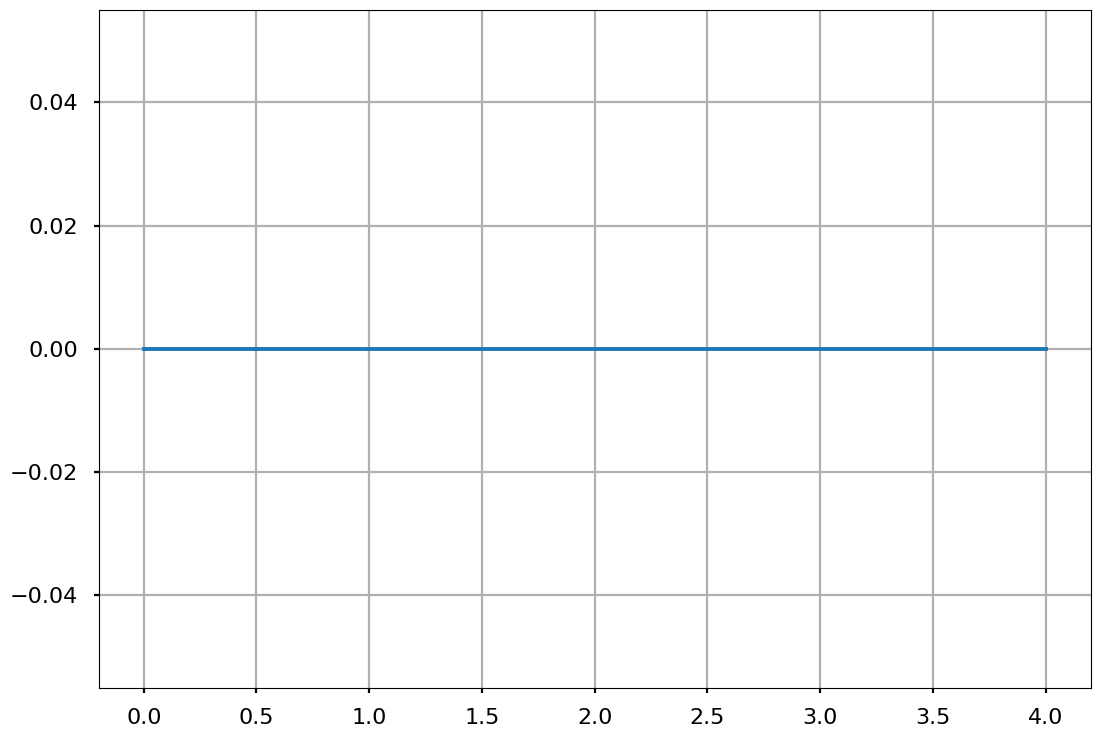

In [28]:
u = res.y[7]*0.1
plt.plot(t,u)
plt.grid()

## Schießverfahren
Behandlung der Ranwerte wie Anfangsbedingungen und aufintegration (Schießen zum Ende)

In [54]:
# Eingangsbeschränkung
umax = 12
def System_dynamic(t,x):
    '''
    x:         [x,lamda]
    '''
    dx = np.zeros(nx*2)

    u       = -1/R*(x[5]*m*a*np.cos(x[0])/(J+m*a**2) + x[7])        
    u       = min(umax,max(-umax,u))        
    dx[0] = x[1]
    dx[1] = (m*g*np.sin(x[1])+m*a*np.cos(x[0])*u-d*x[1])/(J+m*a**2) 
    dx[2] = x[3]
    dx[3] = u
    dx[nx:nx*2] = -Q@x[:nx] - dfdx(x[:nx],u)@x[nx:nx*2]
    return dx

x0 = [np.pi, 0,0,0, 10,4,1,5]
xf = [0,0,0,0 ,0,0,0,0]

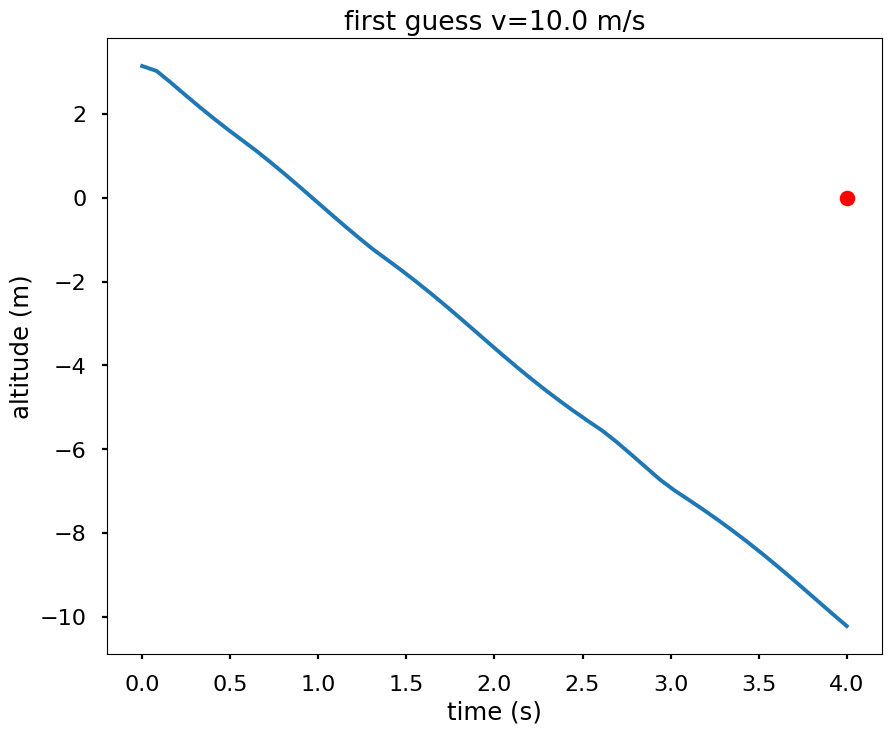

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
plt.style.use('seaborn-poster')



t_span = np.linspace(0, t_end, 100)

t_eval = np.linspace(0, t_end, N)
sol = solve_ivp(System_dynamic, [0, t_end], \
                x0, t_eval = t_eval)

plt.figure(figsize = (10, 8))
plt.plot(sol.t, sol.y[0])
plt.plot(t_end, 0, 'ro')
plt.xlabel('time (s)')
plt.ylabel('altitude (m)')
plt.title(f'first guess v={v0} m/s')
plt.show()

In [56]:


# We define the derivative of the shooting function and use it for the resolution of S=0.
# Previously, the Jacobian was computed by finite differences.
# We do not provide S'(p0) but S'(p0).dp0.
# In our scalar case, it is quite similar but in general, it simpler to provide S'(p0).dp0.

def dshoot(p0, dp0):
    t0        = 0.0
    tf        = 1.0
    x0        = np.array([-1.0])
    (xf, dxf), _ = f(t0, x0, (p0, dp0), tf)
    ds = dxf
    return ds

shoot   = nt.tools.tensorize(dshoot)(shoot) # the use of tensorize permits to code S'(p0).dp0 instead of S'(p0)

# The shooting method: resolution of the shooting equation
p0_guess = np.array([1.0])
sol      = nt.nle.solve(shoot, p0_guess, df=shoot);
p0_sol   = sol.x

print('NLE\t: ', '\n\n p0_sol =', p0_sol, '\n shoot  =', shoot(p0_sol), '\n')







# Definition of the maximized Hamiltonian and its derivatives

def dhfun(t, x, dx, p, dp):
    # dh = dh_x dx + dh_p dp
    hd = np.dot(p, dp)
    return hd

def d2hfun(t, x, dx, d2x, p, dp, d2p):
    # d2h = dh_xx dx d2x + dh_xp dp d2x + dh_px dx d2p + dh_pp dp d2p
    hdd = np.dot(d2p, dp)
    return hdd

@tools.tensorize(dhfun, d2hfun, tvars=(2, 3))
def hfun(t, x, p):
    h =  0.5*np.dot(p, p)
    return h

h = ocp.Hamiltonian(hfun)   # The Hamiltonian object

f = ocp.Flow(h)             # The flow associated to the Hamiltonian object is
                            # the exponential mapping with its derivative
                            # that can be used to define the Jacobian of the
                            # shooting function

# Definition of the shooting function and its derivative
# the use of tensorize permits to code S'(p0).dp0 instead of S'(p0)
def dshoot(p0, dp0):
    t0 = 0.0
    tf = 1.0
    A  = np.array([ 0.0, 0.0])
    (xf, dxf), _ = f(t0, A, (p0, dp0), tf)
    ds = dxf
    return ds

@tools.tensorize(dshoot)
def shoot(p0):
    t0     = 0.0
    tf     = 1.0
    A      = np.array([ 0.0, 0.0])
    B      = np.array([ 1.0, 1.0])
    xf, pf = f(t0, A, p0, tf)  # We use the flow to get z(tf, x0, p0)
    s = xf - B                  # x(tf, x0, p0) - B
    return s

# The shooting method: resolution of the shooting equation
p0_guess = np.array([0.1, 0.1])
sol      = nt.nle.solve(shoot, p0_guess, df=shoot);
p0_sol   = sol.x

print('NLE\t: ', '\n\n p0_sol =', p0_sol, '\n shoot  =', shoot(p0_sol), '\n')

NameError: name 'tools' is not defined